<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/Scikit_learn_implementation_of_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective:

Business often possesses large amount of text documents such as customer reviews, technician logs or legal documents. To find potential business opprtunities, data scientists utilize topic modeling techniques which often provide quick ways of gaining insights from large amount of text documents. LDA model is one of most popular unsupervised learning approches that help achieving this goal when there are no pre-known topics. Popular data scinece packages such as Gensim, Mallet and Scikit-learn provide such implementation. The exercise in this notebook demonstrates this powerful analysis by utilizing Sk-learn LDA implementations to extract topics from '20 news group' data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Install additioanal Packages
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 16.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=20560f80c64a5ebeba0c747e8fc57cc6135695d4be5d1615cad8d6b6e7a2f44c
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=ceb5d71b085c440ae090a737c5f01cd86db437edee28dd69fd23655f7d8eea1b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np

import re, nltk, spacy, gensim, pickle
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%pprint

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Pretty printing has been turned OFF


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')


In [ ]:
# Examine data
print('20 Unique Topics:  ', df.target_names.unique())
print('Number of Documents:  ', len(df.content), 'documents')
df.head()

20 Unique Topics:   ['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']
Number of Documents:   11314 documents


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


Though the study is focused on unsupervised learning (assume no pre-known document labels), let's cheat a little by peeking into the given groups so we roughly know how many groups to expect from the optimized model.

In [ ]:
known_topic_dist=df.target_names.value_counts().reset_index()
known_topic_dist.columns = ['Category', 'Document Num']
known_topic_dist

,Category,Document Num
0,rec.sport.hockey,600
1,soc.religion.christian,599
2,rec.motorcycles,598
3,rec.sport.baseball,597
4,sci.crypt,595
5,rec.autos,594
6,sci.med,594
7,comp.windows.x,593
8,sci.space,593
9,sci.electronics,591


In [ ]:
known_topic_dist[['Part1','Part2','Part3','Part4', 'Part5']]=known_topic_dist.Category.str.split(".",expand=True,)
Main_categroy=known_topic_dist.groupby('Part1').agg(sum).reset_index()
Main_categroy.columns=['Category', 'Document Num']
Main_categroy

,Category,Document Num
0,alt,480
1,comp,2936
2,misc,585
3,rec,2389
4,sci,2373
5,soc,599
6,talk,1952


In [ ]:
# Text data preparation:

# Convert to list
docs_raw = df.content.values.tolist()

# Remove Emails
docs_raw  = [re.sub(r'\S*@\S*\s?', '', sent) for sent in docs_raw ]

# Remove new line characters
docs_raw  = [re.sub(r'\s+', ' ', sent) for sent in docs_raw]

# Remove distracting single quotes
docs_raw  = [re.sub(r"\'", "", sent) for sent in docs_raw ]

In [ ]:
# Lemmatize with POS Tag (NLTK)
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) # if the tag not listed in tag_dict, treat it as NOUN

In [ ]:
# Define Tokenizer and Lemmatizer
tokenizer = RegexpTokenizer(r'\b[a-zA-Z]{3,}\b')
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    return [self.wnl.lemmatize(t, get_wordnet_pos(t)) for t in tokenizer.tokenize(doc)]


In [ ]:
from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS.union(["max", "thanks","just", "right", "like", 'from', 'subject', 're', 'use'])
# 'right', 'like' are though with sentiment are excluded in this exercise as sentiment is not the focus here

In [ ]:
# Term-frequency coverter converts collection of text documents to a matrix of token counts (bow)
%%time 
tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents = 'unicode',  # use any character
                                ngram_range=(1,2), # Look for 1,2 grams, any infrequent or over frequent n-gram tokens will be excluded
                                stop_words = my_stop_words, # filter out english stop words
                                lowercase = True, # convert to lower case letters
                                token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                max_df = 0.40, # filter out terms shown in >40% of documents (Over frequent/common)
                                min_df = 10) # filter out terms shown less than 10 times


dtm_tf = tf_vectorizer.fit_transform(docs_raw) # use the converter convert the document into bow vectors
print(dtm_tf.shape) #sk-learn CountVectorizer keeps all ngram tokens it finds, regardless if repetitive
#tf_vectorizer.vocabulary_

#If using Tf-idf vector instead of bow
#tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params()) # Tf-idf vector, ** use the parameters from previous setting
#dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
#print(dtm_tfidf.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(11314, 19388)
CPU times: user 4min 17s, sys: 14.3 s, total: 4min 31s
Wall time: 4min 31s


In [ ]:
# Save to trained vector model in case of disruption
model_save_name = "tf_vectorizer.pkl"
path = F"/content/drive/My Drive/{model_save_name}" 
with open(path, 'wb') as file:
    pickle.dump(tf_vectorizer, file)


# Save to trained vector model in case of disruption
model_save_name = "vector_transformed_input.pkl"
path = F"/content/drive/My Drive/{model_save_name}" 
with open(path, 'wb') as file:
    pickle.dump(dtm_tf, file)


In [ ]:
# Load the trained model
model_load_name = "tf_vectorizer.pkl"
path = F"/content/drive/My Drive/{model_load_name}" 
with open(path, 'rb') as file:
  fitted_tf_vectorizer = pickle.load(file)



In [ ]:
# Load term vector
model_load_name = "vector_transformed_input.pkl"
path = F"/content/drive/My Drive/{model_load_name}" 
with open(path, 'rb') as file:
  term_vector = pickle.load(file)

In [ ]:
dtm_tf = fitted_tf_vectorizer.transform(docs_raw)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
# Make sure data sparsity is not exemely high (e.g. 99%)
# Dense high dimentional vector
data_dense = term_vector.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.4678749548815278 %


In [ ]:
%%time 
# Define Search Param
search_params = {'n_components': [1, 5,10,20, 25], 'learning_decay': [.5, .7, .8 ]}

# Init the Model
lda = LatentDirichletAllocation(random_state=10) 

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(term_vector)

CPU times: user 1h 23min 15s, sys: 34min 57s, total: 1h 58min 12s
Wall time: 1h 16min


In [ ]:
# Save to trained model in case of disruption
model_save_name = "pickle_model.pkl"
path = F"/content/drive/My Drive/{model_save_name}" 

with open(path, 'wb') as file:
    pickle.dump(model, file)



In [ ]:
# Load the trained model
model_save_name = "pickle_model.pkl"
path = F"/content/drive/My Drive/{model_save_name}" 
with open(path, 'rb') as file:
  CV_model = pickle.load(file)
    
best_model=CV_model.best_estimator_


In [ ]:
# Observe performance score with the best selected model hyperparameters

# Best Model
best_lda_model = CV_model.best_estimator_
# Model Parameters
print("Best Model's Params: ", CV_model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", CV_model.best_score_)
# Perplexity
print("Model Perplexity: ", best_model.perplexity(term_vector))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -2623696.7227928187
Model Perplexity:  4260.882701220376


In [ ]:
lda_output=CV_model.best_estimator_.transform(fitted_tf_vectorizer)
# the model was already fit on full training data automatically by GridsearchCV(), no need refit with fit_transform()

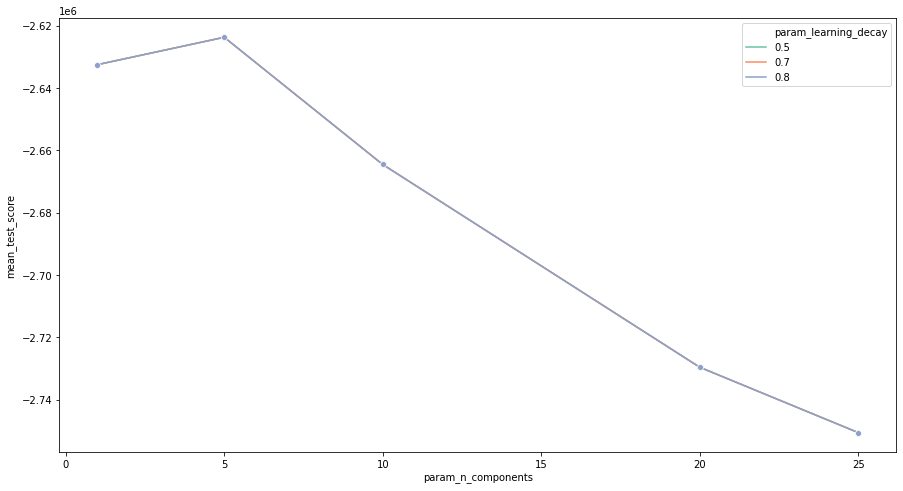

In [ ]:
# Visualize model performance under different settings
import seaborn as sns
results = pd.DataFrame(CV_model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(15,8))

sns.lineplot(data=results,
x='param_n_components',
y='mean_test_score',
hue='param_learning_decay',
palette=current_palette,
marker='o'
)
plt.show()

Grid search cross validation measured on 'Log Likelihood Score' suggests 5 topics is an optimal solution to group given documents. Learning rate doesn't seem playing a role here.

In [ ]:
# Visualize LDA model with pyLDAvis:

pyLDAvis.sklearn.prepare(best_model, term_vector, fitted_tf_vectorizer,  sort_topics=False) #model, vector, vectorizer


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025636  0.082382       1        1  12.576346
1     -0.053776  0.078745       2        1  21.436943
2      0.111349  0.046457       3        1  23.422359
3      0.107617 -0.142951       4        1  14.866571
4     -0.190826 -0.064633       5        1  27.697782, topic_info=             Term         Freq        Total Category  logprob  loglift
6510          god  3081.000000  3081.000000  Default  30.0000  30.0000
18777      window  3029.000000  3029.000000  Default  29.0000  29.0000
6861          gun  1709.000000  1709.000000  Default  28.0000  28.0000
5846         file  3067.000000  3067.000000  Default  27.0000  27.0000
6653   government  1949.000000  1949.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
18459        want  1153.885723  3570.251985   Topic5  -5.8820   0.1543
11088         new  1159.411752  3940.461279   Topic5  -5.8772   0.0604
17148        time  1131.732493  5008.203487   Topic5  -5.9014  -0.2035
4651         dont  1129.260019  5752.634925   Topic5  -5.9036  -0.3443
9846         make  1116.006247  5880.884747   Topic5  -5.9154  -0.3781

[433 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
84         2  0.990771  access digex
215        4  0.991130           adl
290        1  0.074766        agency
290        2  0.070235        agency
290        3  0.049844        agency
...      ...       ...           ...
19244      3  0.153329          year
19244      4  0.141867          year
19244      5  0.069787          year
19277      1  0.992573         yeast
19382      2  0.987759       zoology

[938 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [ ]:
# Showing top selected terms for each topic.

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
n_top_words=20
tf_feature_names = fitted_tf_vectorizer.get_feature_names()
print_top_words(best_model, tf_feature_names, n_top_words)

Topic #0: use say make dont people know think university time edu work thing year health case line article want tax state food
Topic #1: year game university space team car good dont think time make new know say look player line article play distribution win
Topic #2: say god people know think dont make christian come believe time jesus thing way question life israel want jew mean
Topic #3: gun government people key use law state armenian encryption make say clipper chip american weapon new public turkish time year
Topic #4: use window file university program work know drive problem need mail edu run computer version card bit software include help



In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,3959
1,1,3000
2,2,2025
3,0,1274
4,3,1056


Sk-learn topic model summarizes the text document into 5 groups. Based on reading selected key words, the five topics are from 1.Education and Health Science, 2.Sports, 3.Religion, 4.Goverment and 5.Computer Technology. The grouping from the LDA model roughly alligns with the pre-known seven main groups of the text documents. Also noting that through trailing on different lambda value in pyLDAVis visualization, it may highlight more interesting topic related words.

In [ ]:
# Major topic for each Document

# Create Document - Topic Matrix
lda_output = best_model.transform(term_vector)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs_raw))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold).format('{0:,.02f}')
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.00,0.99,0.00,0.00,0.00,1.00
Doc1,0.00,0.16,0.00,0.00,0.83,4.00
Doc2,0.00,0.31,0.14,0.00,0.55,4.00
Doc3,0.00,0.37,0.00,0.00,0.62,4.00
Doc4,0.00,0.58,0.00,0.00,0.41,1.00
Doc5,0.02,0.00,0.00,0.98,0.00,3.00
Doc6,0.31,0.12,0.00,0.00,0.56,4.00
Doc7,0.00,0.00,0.00,0.00,1.00,4.00
Doc8,0.01,0.01,0.01,0.01,0.97,4.00
Doc9,0.00,0.21,0.00,0.00,0.78,4.00


##
 Predict topic for new documents:

In [ ]:


new_text=['UAB hospital provides one of best residency program in the country.']

# Text data preparation:
def data_prep(docs_raw):
# Remove Emails
  docs_raw  = [re.sub(r'\S*@\S*\s?', '', sent) for sent in docs_raw ]

# Remove new line characters
  docs_raw  = [re.sub(r'\s+', ' ', sent) for sent in docs_raw]

# Remove distracting single quotes
  docs_raw  = [re.sub(r"\'", "", sent) for sent in docs_raw ]
  return docs_raw


new_dtm_tf = fitted_tf_vectorizer.transform(data_prep(new_text))


In [ ]:
print(best_model.transform(new_dtm_tf))
print('Topic:', np.argmax(best_model.transform(new_dtm_tf)))

# Prediction result classify the new text into the 'Educaiton and Health Care' topic with strong probabiliy score (0.91)

[[0.88316883 0.02909795 0.02910159 0.02922844 0.02940319]]
Topic: 0


## Find Similar Documents:

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents=lda_output, top_n=5, verbose=False):
    x  = best_model.transform(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        #print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)
# Get similar documents

In [ ]:
# Get similar documents
doc_ids, docs = similar_documents(text=new_dtm_tf, doc_topic_probs=lda_output, documents =docs_raw, top_n=1, verbose=True)
print('\n', docs)

# The most document similar to the test input is also health care related

Topic Prob Scores of text:  [[0.9 0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.9 0.  0.  0.  0. ]]

 ['From: (Mike E. Romano) Subject: Home Medical Tests Organization: Case Western Reserve University, Cleveland, Ohio (USA) Lines: 21 NNTP-Posting-Host: hela.ins.cwru.edu I am looking for current sources for lists of all the home medical tests currently legally available. I believe this trend of allowing tests at home where feasible, decreased medical costs by a factor of 10 or more and allows the patient some time and privacy to consider the best action from the results of such tests. In fact I believe home medical tests and certain basic tests for serious diseases such as cancer, heart disease, should be offered free to the American public. This could actually help to reduce national medical costs since many would have an earlier opportunity to know about and work toward recuperation or cure. Mike Romano -- Sir, I admit your genral rule That every poet is a fool; But you yourself m

In [ ]:
best_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=10, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## Conclusion:

This exercise provides an actionable Topic Modeling solution with sk-learn implementations. Resulted groups captured most main subjects covered by the document in the area of 1.Education and Health Science, 2.Sports, 3.Religion, 4.Goverment and 5.Computer Technology and can be used to categorize new texts into these categories. However, the model takes long time and large computing resource when fine-tuning for optimal number of topics but still miss granular level of grouping (known 20 new group). 

To enhence model performance, next step may include but not limited to more detailed text pre-processing, increase model training iteration, use tf-idf vectorizer instead of simple term frequency vectorizer or try other model implementations such as Gensim and Mallet used in another exercise.